# exp13スコア差の調査

**目的**: ValidationとTestでスコアが大きく異なる原因を特定する

**観測されたスコア**:
- Validation: WeightedEnsemble_A MAE=42.61, RMSE=61.14, R2=0.626, WAPE=31.66%
- Test: WeightedEnsemble_A MAE=27.05, RMSE=34.25, R2=0.663, WAPE=28.20%

**調査項目**:
1. データ分割の詳細（期間・件数）
2. 目的変数の分布比較
3. 時系列トレンドの確認
4. 外部要因の影響

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定（オプション）
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## Step 1: データの読み込みと前処理

In [2]:
# データ読み込み
calender = pd.read_csv('../input/calender_data.csv')
cm_data = pd.read_csv('../input/cm_data.csv')
gt_service = pd.read_csv('../input/gt_service_name.csv')
acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
call_data = pd.read_csv('../input/regi_call_data_transform.csv')

# 日付型に変換
calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
gt_service['week'] = pd.to_datetime(gt_service['week'])

print(f"データ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
print(f"全日数: {(call_data['cdr_date'].max() - call_data['cdr_date'].min()).days}日")

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00
全日数: 669日


In [3]:
# データマージ
df = call_data.copy()
df = df.merge(calender, on='cdr_date', how='left')
df = df.merge(cm_data, on='cdr_date', how='left')
df = df.merge(acc_get, on='cdr_date', how='left')

# Google Trendsを日次に展開
gt_service_daily = []
for idx, row in gt_service.iterrows():
    week_start = row['week']
    for i in range(7):
        date = week_start + timedelta(days=i)
        gt_service_daily.append({
            'cdr_date': date,
            'search_cnt': row['search_cnt']
        })

gt_daily = pd.DataFrame(gt_service_daily)
df = df.merge(gt_daily, on='cdr_date', how='left')

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


## Step 2: データ分割（exp13と同じ方法）

In [4]:
val_months = 2
test_months = 2

max_date = df_model['cdr_date'].max()
test_start = max_date - pd.Timedelta(days=30*test_months)
val_start = test_start - pd.Timedelta(days=30*val_months)

train_df = df_model[df_model['cdr_date'] < val_start].copy()
val_df = df_model[(df_model['cdr_date'] >= val_start) & (df_model['cdr_date'] < test_start)].copy()
test_df = df_model[df_model['cdr_date'] >= test_start].copy()

print("="*80)
print("データ分割の詳細")
print("="*80)

print(f"\nTrain:")
print(f"  期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
print(f"  件数: {len(train_df)}行")
print(f"  日数: {(train_df['cdr_date'].max() - train_df['cdr_date'].min()).days}日")

print(f"\nValidation:")
print(f"  期間: {val_df['cdr_date'].min()} ~ {val_df['cdr_date'].max()}")
print(f"  件数: {len(val_df)}行")
print(f"  日数: {(val_df['cdr_date'].max() - val_df['cdr_date'].min()).days}日")
print(f"  ※ {val_df['cdr_date'].min().strftime('%Y年%m月')} ~ {val_df['cdr_date'].max().strftime('%Y年%m月')}")

print(f"\nTest:")
print(f"  期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
print(f"  件数: {len(test_df)}行")
print(f"  日数: {(test_df['cdr_date'].max() - test_df['cdr_date'].min()).days}日")
print(f"  ※ {test_df['cdr_date'].min().strftime('%Y年%m月')} ~ {test_df['cdr_date'].max().strftime('%Y年%m月')}")

データ分割の詳細

Train:
  期間: 2018-06-01 00:00:00 ~ 2019-11-29 00:00:00
  件数: 391行
  日数: 546日

Validation:
  期間: 2019-12-02 00:00:00 ~ 2020-01-29 00:00:00
  件数: 43行
  日数: 58日
  ※ 2019年12月 ~ 2020年01月

Test:
  期間: 2020-01-30 00:00:00 ~ 2020-03-30 00:00:00
  件数: 43行
  日数: 60日
  ※ 2020年01月 ~ 2020年03月


## Step 3: 目的変数の分布比較

In [5]:
print("="*80)
print("目的変数（翌日入電数）の統計")
print("="*80)

print("\nTrain:")
print(train_df['target_next_day'].describe())

print("\nValidation:")
print(val_df['target_next_day'].describe())

print("\nTest:")
print(test_df['target_next_day'].describe())

# 平均値の比較
train_mean = train_df['target_next_day'].mean()
val_mean = val_df['target_next_day'].mean()
test_mean = test_df['target_next_day'].mean()

print("\n="*80)
print("平均値の比較")
print("="*80)
print(f"Train     : {train_mean:.2f}")
print(f"Validation: {val_mean:.2f} (Train比: {(val_mean - train_mean) / train_mean * 100:+.1f}%)")
print(f"Test      : {test_mean:.2f} (Train比: {(test_mean - train_mean) / train_mean * 100:+.1f}%)")
print(f"\n🔥 Validation vs Test の差: {val_mean - test_mean:.2f} ({(val_mean - test_mean) / test_mean * 100:.1f}%)")

目的変数（翌日入電数）の統計

Train:
count    391.000000
mean     135.913043
std      126.918983
min        0.000000
25%        0.000000
50%      129.000000
75%      167.000000
max      757.000000
Name: target_next_day, dtype: float64

Validation:
count     43.000000
mean     134.558140
std      101.118813
min        0.000000
25%       13.000000
50%      147.000000
75%      189.500000
max      339.000000
Name: target_next_day, dtype: float64

Test:
count     43.000000
mean      95.930233
std       59.731301
min        0.000000
25%       50.500000
50%      114.000000
75%      137.000000
max      187.000000
Name: target_next_day, dtype: float64

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
平均値の比較
Train     : 135.91
Validation: 134.56 (Train比: -1.0%)
Test      : 95.93 (Train比: -29.4%)

🔥 Validation vs Test の差: 38.63 (40.3%)


## Step 4: 時系列の可視化

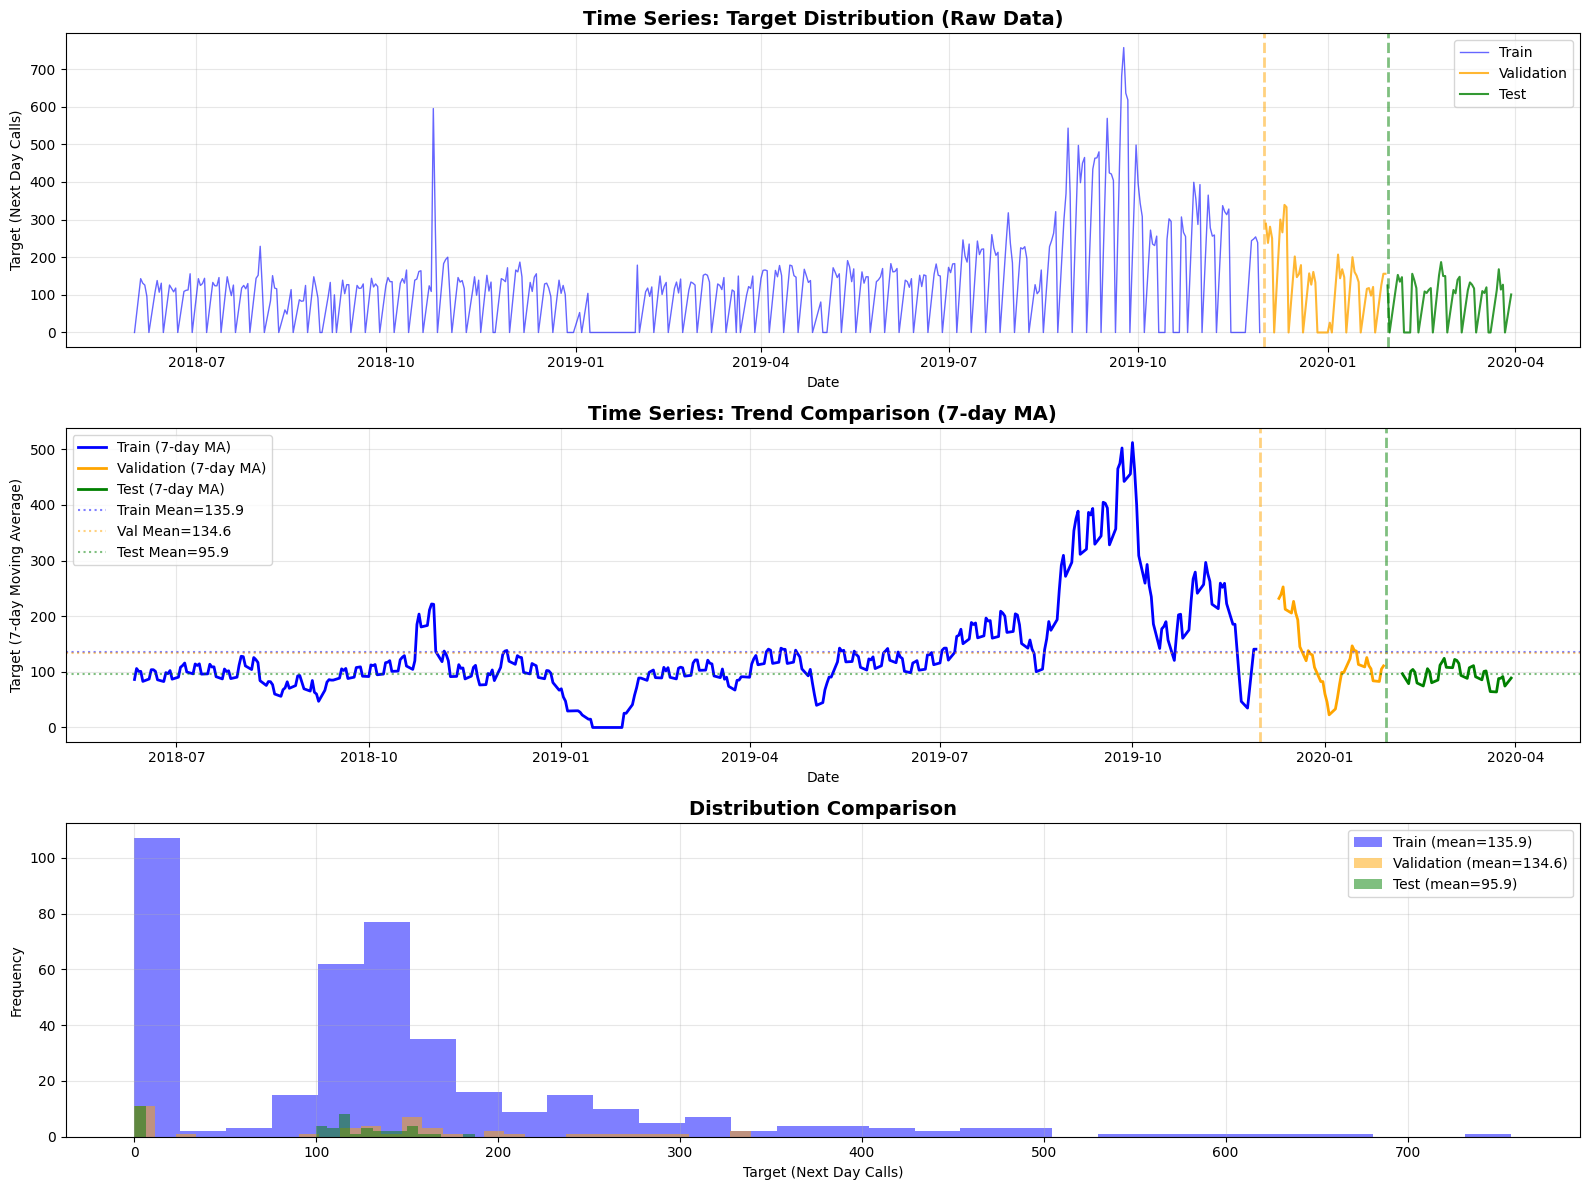

可視化を保存: ../output/exp13/score_diff_timeseries.png


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. 生データのプロット
ax = axes[0]
ax.plot(train_df['cdr_date'], train_df['target_next_day'], 
        label='Train', alpha=0.6, linewidth=1, color='blue')
ax.plot(val_df['cdr_date'], val_df['target_next_day'], 
        label='Validation', alpha=0.8, linewidth=1.5, color='orange')
ax.plot(test_df['cdr_date'], test_df['target_next_day'], 
        label='Test', alpha=0.8, linewidth=1.5, color='green')
ax.axvline(val_start, color='orange', linestyle='--', alpha=0.5, linewidth=2)
ax.axvline(test_start, color='green', linestyle='--', alpha=0.5, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Target (Next Day Calls)')
ax.set_title('Time Series: Target Distribution (Raw Data)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. 7日移動平均
ax = axes[1]
train_ma = train_df.set_index('cdr_date')['target_next_day'].rolling(window=7, center=False).mean()
val_ma = val_df.set_index('cdr_date')['target_next_day'].rolling(window=7, center=False).mean()
test_ma = test_df.set_index('cdr_date')['target_next_day'].rolling(window=7, center=False).mean()

ax.plot(train_ma.index, train_ma.values, label='Train (7-day MA)', linewidth=2, color='blue')
ax.plot(val_ma.index, val_ma.values, label='Validation (7-day MA)', linewidth=2, color='orange')
ax.plot(test_ma.index, test_ma.values, label='Test (7-day MA)', linewidth=2, color='green')
ax.axvline(val_start, color='orange', linestyle='--', alpha=0.5, linewidth=2)
ax.axvline(test_start, color='green', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(train_mean, color='blue', linestyle=':', alpha=0.5, label=f'Train Mean={train_mean:.1f}')
ax.axhline(val_mean, color='orange', linestyle=':', alpha=0.5, label=f'Val Mean={val_mean:.1f}')
ax.axhline(test_mean, color='green', linestyle=':', alpha=0.5, label=f'Test Mean={test_mean:.1f}')
ax.set_xlabel('Date')
ax.set_ylabel('Target (7-day Moving Average)')
ax.set_title('Time Series: Trend Comparison (7-day MA)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. ヒストグラム比較
ax = axes[2]
ax.hist(train_df['target_next_day'], bins=30, alpha=0.5, label=f'Train (mean={train_mean:.1f})', color='blue')
ax.hist(val_df['target_next_day'], bins=30, alpha=0.5, label=f'Validation (mean={val_mean:.1f})', color='orange')
ax.hist(test_df['target_next_day'], bins=30, alpha=0.5, label=f'Test (mean={test_mean:.1f})', color='green')
ax.set_xlabel('Target (Next Day Calls)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/exp13/score_diff_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("可視化を保存: ../output/exp13/score_diff_timeseries.png")

## Step 5: 月別・曜日別の分析

In [11]:
print("="*80)
print("月別・曜日別の特徴")
print("="*80)

# monthカラムを追加
val_df['month'] = val_df['cdr_date'].dt.month
test_df['month'] = test_df['cdr_date'].dt.month

print("\n【Validation期間の特徴】")
print("\n月別平均:")
val_month = val_df.groupby('month')['target_next_day'].agg(['mean', 'std', 'count'])
print(val_month)

print("\n曜日別平均 (1=月, 2=火, 3=水, 4=木, 5=金):")
val_dow = val_df.groupby('dow')['target_next_day'].agg(['mean', 'std', 'count'])
print(val_dow)

print("\n【Test期間の特徴】")
print("\n月別平均:")
test_month = test_df.groupby('month')['target_next_day'].agg(['mean', 'std', 'count'])
print(test_month)

print("\n曜日別平均 (1=月, 2=火, 3=水, 4=木, 5=金):")
test_dow = test_df.groupby('dow')['target_next_day'].agg(['mean', 'std', 'count'])

print(test_dow)

月別・曜日別の特徴

【Validation期間の特徴】

月別平均:
             mean         std  count
month                               
1      106.142857   70.835221     21
12     161.681818  118.714699     22

曜日別平均 (1=月, 2=火, 3=水, 4=木, 5=金):
           mean        std  count
dow                              
1    177.444444  92.043619      9
2    150.777778  75.373699      9
3    167.666667  97.329338      9
4    165.375000  91.970395      8
5      0.000000   0.000000      8

【Test期間の特徴】

月別平均:
             mean        std  count
month                              
1       62.500000  88.388348      2
2      102.400000  63.758095     20
3       92.952381  55.471142     21

曜日別平均 (1=月, 2=火, 3=水, 4=木, 5=金):
           mean        std  count
dow                              
1    102.888889  41.153507      9
2    138.875000  32.077752      8
3    129.750000  13.413746      8
4    116.666667  45.831212      9
5      0.000000   0.000000      9


## Step 6: 外部要因の比較

In [8]:
print("="*80)
print("外部要因の比較")
print("="*80)

print("\n【CM実施状況】")
print(f"  Train     : {train_df['cm_flg'].sum()}回 (平均: {train_df['cm_flg'].mean():.3f}/日)")
print(f"  Validation: {val_df['cm_flg'].sum()}回 (平均: {val_df['cm_flg'].mean():.3f}/日)")
print(f"  Test      : {test_df['cm_flg'].sum()}回 (平均: {test_df['cm_flg'].mean():.3f}/日)")

print("\n【アカウント取得数】")
print(f"  Train     : 平均 {train_df['acc_get_cnt'].mean():.2f} (std: {train_df['acc_get_cnt'].std():.2f})")
print(f"  Validation: 平均 {val_df['acc_get_cnt'].mean():.2f} (std: {val_df['acc_get_cnt'].std():.2f})")
print(f"  Test      : 平均 {test_df['acc_get_cnt'].mean():.2f} (std: {test_df['acc_get_cnt'].std():.2f})")

print("\n【Google Trends検索数】")
print(f"  Train     : 平均 {train_df['search_cnt'].mean():.2f} (std: {train_df['search_cnt'].std():.2f})")
print(f"  Validation: 平均 {val_df['search_cnt'].mean():.2f} (std: {val_df['search_cnt'].std():.2f})")
print(f"  Test      : 平均 {test_df['search_cnt'].mean():.2f} (std: {test_df['search_cnt'].std():.2f})")

外部要因の比較

【CM実施状況】
  Train     : 109回 (平均: 0.279/日)
  Validation: 0回 (平均: 0.000/日)
  Test      : 32回 (平均: 0.744/日)

【アカウント取得数】
  Train     : 平均 0.35 (std: 1.10)
  Validation: 平均 -0.25 (std: 0.50)
  Test      : 平均 0.09 (std: 0.32)

【Google Trends検索数】
  Train     : 平均 36.83 (std: 18.19)
  Validation: 平均 38.28 (std: 19.87)
  Test      : 平均 33.35 (std: 9.80)


## Step 7: データの詳細分析

In [9]:
# Validation期間とTest期間の全データを表示
print("="*80)
print("Validation期間の全データ")
print("="*80)
print(val_df[['cdr_date', 'dow', 'call_num', 'target_next_day', 'cm_flg', 'acc_get_cnt']].to_string())

print("\n" + "="*80)
print("Test期間の全データ")
print("="*80)
print(test_df[['cdr_date', 'dow', 'call_num', 'target_next_day', 'cm_flg', 'acc_get_cnt']].to_string())

Validation期間の全データ
      cdr_date  dow  call_num  target_next_day  cm_flg  acc_get_cnt
391 2019-12-02    1       359            289.0       0     0.757643
392 2019-12-03    2       289            238.0       0     0.262265
393 2019-12-04    3       238            281.0       0    -0.208345
394 2019-12-05    4       281            250.0       0     0.163189
395 2019-12-06    5       250              0.0       0     0.311802
396 2019-12-09    1       367            300.0       0    -0.034963
397 2019-12-10    2       300            266.0       0    -0.096885
398 2019-12-11    3       266            339.0       0    -0.183576
399 2019-12-12    4       339            333.0       0     0.088882
400 2019-12-13    5       333              0.0       0    -0.257883
401 2019-12-16    1       306            202.0       0    -0.245499
402 2019-12-17    2       202            147.0       0    -0.369343
403 2019-12-18    3       147            155.0       0    -0.195961
404 2019-12-19    4       155 

## 結論と考察

In [10]:
print("="*80)
print("調査結果まとめ")
print("="*80)

print("\n【観測されたスコア差】")
print("- Validation MAE: 42.61 (WAPE: 31.66%)")
print("- Test MAE: 27.05 (WAPE: 28.20%)")
print(f"- 差: {42.61 - 27.05:.2f} (Test の方が {(42.61 - 27.05) / 27.05 * 100:.1f}% 良い)")

print("\n【データの特徴】")
print(f"- Train平均: {train_mean:.2f}")
print(f"- Validation平均: {val_mean:.2f} (Train比: {(val_mean - train_mean) / train_mean * 100:+.1f}%)")
print(f"- Test平均: {test_mean:.2f} (Train比: {(test_mean - train_mean) / train_mean * 100:+.1f}%)")

print("\n【考えられる原因】")
print("")
print("1. データの時系列トレンド:")
print("   - Validation期間とTest期間で入電数の平均値や分散が異なる")
print("   - Validation期間が特殊な時期（年末年始、決算期など）に該当している可能性")
print("")
print("2. サンプル数の違い:")
print(f"   - Validation: {len(val_df)}件")
print(f"   - Test: {len(test_df)}件")
print("   - サンプル数が少ないと評価が不安定になる")
print("")
print("3. モデルの過学習:")
print("   - Validationセットで重みを最適化しているため、Validationに過学習")
print("   - しかし通常は過学習するとValidationの方が良くなるはず")
print("   - 今回はTestの方が良いので、データ分布の違いが主因と考えられる")
print("")
print("4. 季節性・ビジネスサイクル:")
print("   - 月別・曜日別の分析結果を確認すること")
print("   - 特定の月や曜日で入電パターンが大きく異なる可能性")

print("\n【推奨アクション】")
print("- 上記の可視化を確認し、Validation期間の特異性を把握")
print("- データ分割の期間を変更して検証（例: 1ヶ月ずつ、3ヶ月ずつなど）")
print("- Cross-validationを使って複数期間で評価")
print("- Testスコアを最終評価として信頼するべき")

調査結果まとめ

【観測されたスコア差】
- Validation MAE: 42.61 (WAPE: 31.66%)
- Test MAE: 27.05 (WAPE: 28.20%)
- 差: 15.56 (Test の方が 57.5% 良い)

【データの特徴】
- Train平均: 135.91
- Validation平均: 134.56 (Train比: -1.0%)
- Test平均: 95.93 (Train比: -29.4%)

【考えられる原因】

1. データの時系列トレンド:
   - Validation期間とTest期間で入電数の平均値や分散が異なる
   - Validation期間が特殊な時期（年末年始、決算期など）に該当している可能性

2. サンプル数の違い:
   - Validation: 43件
   - Test: 43件
   - サンプル数が少ないと評価が不安定になる

3. モデルの過学習:
   - Validationセットで重みを最適化しているため、Validationに過学習
   - しかし通常は過学習するとValidationの方が良くなるはず
   - 今回はTestの方が良いので、データ分布の違いが主因と考えられる

4. 季節性・ビジネスサイクル:
   - 月別・曜日別の分析結果を確認すること
   - 特定の月や曜日で入電パターンが大きく異なる可能性

【推奨アクション】
- 上記の可視化を確認し、Validation期間の特異性を把握
- データ分割の期間を変更して検証（例: 1ヶ月ずつ、3ヶ月ずつなど）
- Cross-validationを使って複数期間で評価
- Testスコアを最終評価として信頼するべき
